# Week 5: CNN

This week, we will be:

1. Continuing on from week 5 - Training built-in CV algorithm in AWS SageMaker with data in image format
2. Training built-in CV algorithm in AWS SageMaker with images in RecordIO (the recommended) format 


# 1. Preparing raw image data to training a model using a built-in CV algorithm in AWS SageMaker

**Best to create a new notebook instance. Just upload the jupyter notebook file and no directories - as file paths are all written for root directory.**

This section goes over how to load and restructure image data for use with the [Amazon SageMaker image classification algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html). This is a supervised learning algorithm that supports multi-label classification, and used a convolutional neural network (ResNet) that can be terained from scratch, or trained using transfer learning when training images aren't available. 



#### 1. Obtaining the data

Data in this exercise are about dogs and cats images from kaggle.
We will use the terminal in a new notebook instance. 

1. Open a new notebook instance. Open jupyterlab and select the terminal icon. 
2. Obtain the [data from kaggle](https://www.kaggle.com/c/dogs-vs-cats). You will need to have made a kaggle account if you don't already have one.  
3. There are two options for obtaining data from Kaggle 
     - **OPTION 1**: We can download it straight to a SageMake notebook instance using the CurlWget chrome extension and wget as shown [here](https://www.kaggle.com/c/deepfake-detection-challenge/discussion/129521). 
     - **OPTION 2**: Using the Kaggle API -we download a large data directly from a website to AWS SageMaker. Instructions can be found [here](https://github.com/Kaggle/kaggle-api)
     - **OPTION 3**: Download the to our local machine and then upload it to notebook instance (Note: it is not an ideal, especially for large datasets). 

Here, we will demonstrate how to format the data for training built-in SageMaker algorithms.

The following code is from Chapter 5 from the book "Learn Amazon SageMaker" by Julien Simon. 


#### 2. Formatting the data

The Amazon SageMaker built-in Image Classification algorithm supports 3 inputs formats
- image files
- RecordIO files
- Augmented manifest build by SageMaker Grouth Truth
requires that the dataset be formatted in RecordIO.


There is a standard way to store and structure your image data for deep learning that make is fast and efficient to load your data to train and evaluate the model. 

After you have collected your images, we: 
1. Sort by dataset, such as train, test, and validation, and;
2. Sort them by their class. 

    - Note 1: Remember how we loaded the mnist_fashion data - this is one of the ways that data is structured behind the scenes. 
    - Note 2: or small dataset, you can do this in your local machine, as explained [here by Jason Brownlee]
(https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/).

For example, we wish to classify dogs and cats. 

First, we have a `data/` directory where we will store all of the images of dogs and cats in the dataset.
Next, we will have a `data/train/` directory for the training dataset and a `data/test/` for the holdout test dataset. We may also have a `data/validation/` for a validation dataset during training.

We are going to perform this process using AWS SageMaker:

We are aiming for data structure that looks like this: 

In [ ]:
data/
data/train
data/train/cat
data/train/dog
data/validation/
data/validation/cat
data/validation/dog

In [ ]:
# all further code run in the notebook instance terminal
# changing directory permissions

In [ ]:
sudo chown ec2-user lost+found
sudo chgrp ec2-user lost+found

In [ ]:
#unzip data folder
unzip dogs-vs-cats.zip
#unzip training data
unzip train.zip

The dog and cat images are mixed up in the same folder. Therefore we create a subfolder for each class and move the appropriate images into each folder

In [2]:
cd train # move into training folder
mkdir dog cat # creating directories 
mv cat.* cat/ # move all cat images to cat directory
mv dog.* dog/ # move all dog images to dog directory

SyntaxError: invalid syntax (<ipython-input-2-3537d95d1d02>, line 1)

Clean up: Jump back up a directory and delete the directories 
we don't need anymore

In [ ]:
cd ..
ls -l 
rm sampleSubmission.csv #remove unwanted folders
rm test1.zip
rm train.zip
ls -l
mv train data #rename train directory to data
cd data #move into the data directory

We are now going to generate our own validation set to evaluate the performace of the model  containing 1000 dog images and 1000 cat images (not we could have used to in-built test set, but this is to practice generating your own). 

We are going to generate 1000 random dog images and 1000 random cat images to specific directories. 

In [ ]:
mkdir train val#make training and validation directories
mkdir -p val/dog val/cat #make dog and cat directories in val
ls dog | sort -R |tail -1000 | while read file; do mv dog/$file val/dog; done
ls cat | sort -R |tail -1000 | while read file; do mv cat/$file val/cat; done

In [ ]:
mv dog cat train

In [ ]:
du -h

#### 3. Format the data
We need to download the *im2rec* tool from github (https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) to covert the data to image format for built-in CV algorithm.

In [ ]:
wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
pip install mxnet opencv-python

We use im2rec to build two list files **dogscats-train.lst** and **dogscats-val.lst**, one for training data an done for validation data

In [ ]:
python3 im2rec.py --list --recursive dogscats-train train
python3 im2rec.py --list --recursive dogscats-val val

Now we need to move the list files to their own specific directories. This must be done because they will be passed to the estimator (built-in CV algorithm in sagemaker) as two new channels, *train_lst* and *validation_lst*

In [ ]:
mkdir train_lst val_lst
mv dogscats-train.lst train_lst
mv dogscats-val.lst val_lst

View the directories to make sure they look like this:

In [1]:
du -h

NameError: name 'du' is not defined

#### 4. Upload the data to AWS S3 bucket. 

Please check that only 4 folders **train, val, train_lst, val_lst** are uploaded in S3 bucket. **Please change the key to your S3 bucket**.

**NOTE** A change from last week - please add the final directory to the S3 bucket key! 

In [ ]:
aws s3 sync train s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/train
aws s3 sync train_lst s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/train_lst

In [ ]:
aws s3 sync val s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/val
aws s3 sync val_lst s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/val_lst

#### This is where we stopped last week! 
We will now train the built-in CV classification algorithm in SageMaker with the data we just formatted :)

### Train the model using image format using a built-in algorithm in SageMaker

-References:
1. https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html
2. Notebook instance: https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.html

3. The code in this section is from here 
https://github.com/PacktPublishing/Learn-Amazon-SageMaker/blob/master/sdkv2/ch5/Image%20Classification%20on%20Dogs%20vs%20Cats%20(image%20format).ipynb

Note that there are still ongoing progress in documenting the algorithms in AWS so somethimes you might face lack of documentation. The best way to learn is to look at sagemaker notebook and modify their codes to fit your purposes.

#### 5. We first greate a sagemaker session and a boto3 session.

In [1]:
import boto3
import sagemaker

print(sagemaker.__version__)

session = sagemaker.Session()
bucket = session.default_bucket()

2.42.0


#### 6. Next, we define the path to the data in S3

In [8]:
prefix = 'dogscats'

s3_train_path = 's3://{}/{}/input/train/'.format(bucket, prefix)
s3_val_path = 's3://{}/{}/input/val/'.format(bucket, prefix)
s3_train_lst_path = 's3://{}/{}/input/train_lst/'.format(bucket, prefix)
s3_val_lst_path = 's3://{}/{}/input/val_lst/'.format(bucket, prefix)

s3_output = 's3://{}/{}/output/'.format(bucket, prefix)

print(s3_train_path)
print(s3_val_path)
print(s3_train_lst_path)
print(s3_val_lst_path)
print(s3_output)

s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/train/
s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/val/
s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/train_lst/
s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/val_lst/
s3://sagemaker-ap-southeast-2-580121432832/dogscats/output/


#### 7. Get the name of image classification algorithm in your region 

In [3]:
from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('image-classification', region)
print(container)

544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/image-classification:1


#### 8. Set data parameters for training model
There are two kinds of parameters that need to be set for training. 

1. The first one are the parameters for the training job.

These include:

**Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the “InputDataConfig” section. The main parameters that need to be set is the “ContentType” which can be set to “rec” or “lst” based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present.

**Output specification**: We need to specify the S3 path where the output can be stored after training.

**Resource configuration**: We specify the type of instance on which to run the training and the number of hosts used for training. If “InstanceCount” is more than 1, then training can be run in a distributed manner.

2. The second ones are hyperparameters: 

**Hyperparameters**: num_layers. num_training_samples, num_classes, epochs, learning_rate, mini_batch_size

In [9]:
role = sagemaker.get_execution_role()

ic = sagemaker.estimator.Estimator(container,
                                   role, 
                                   instance_count=1, 
                                   instance_type='ml.p2.xlarge',
                                   output_path=s3_output)

In [10]:

train_data = sagemaker.TrainingInput(s3_train_path, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-image',
                                        s3_data_type='S3Prefix')

val_data = sagemaker.TrainingInput(s3_val_path,
                                      distribution='FullyReplicated', 
                                      content_type='application/x-image', 
                                      s3_data_type='S3Prefix')

train_lst_data = sagemaker.TrainingInput(s3_train_lst_path, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-image',
                                        s3_data_type='S3Prefix')

val_lst_data = sagemaker.TrainingInput(s3_val_lst_path,
                                          distribution='FullyReplicated', 
                                          content_type='application/x-image', 
                                          s3_data_type='S3Prefix')

s3_channels = {'train': train_data, 'validation': val_data, 
               'train_lst': train_lst_data, 'validation_lst': val_lst_data}

In [13]:
ic.set_hyperparameters(num_layers=18,               # Train a Resnet-18 layers
                       use_pretrained_model=0,      # Train from scratch; 1 = transfer learning
                       num_classes=2,               # Dogs and cats
                       num_training_samples=22500,  # Number of training samples
                       mini_batch_size=128,
                       resize=224,
                       epochs=2)  

### Train the model

Call the fit method on the estimator

In [12]:
ic.fit(inputs=s3_channels)

2021-05-31 04:11:18 Starting - Starting the training job...
2021-05-31 04:11:45 Starting - Launching requested ML instancesProfilerReport-1622434278: InProgress
......
2021-05-31 04:12:46 Starting - Preparing the instances for training.........
2021-05-31 04:14:09 Downloading - Downloading input data..................
2021-05-31 04:17:17 Training - Downloading the training image...
2021-05-31 04:17:47 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[05/31/2021 04:17:38 INFO 139710696503104] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[05/31/20

### Deploy the model

We now want to use the model to perform inference. e.g. predicting the class of the image. Deploy the created model by using the deploy method on the estimator

In [17]:
ic_predictor = ic.deploy(initial_instance_count=1,
                         instance_type='ml.t2.medium')

---------------------!

### Predict the class of a test image

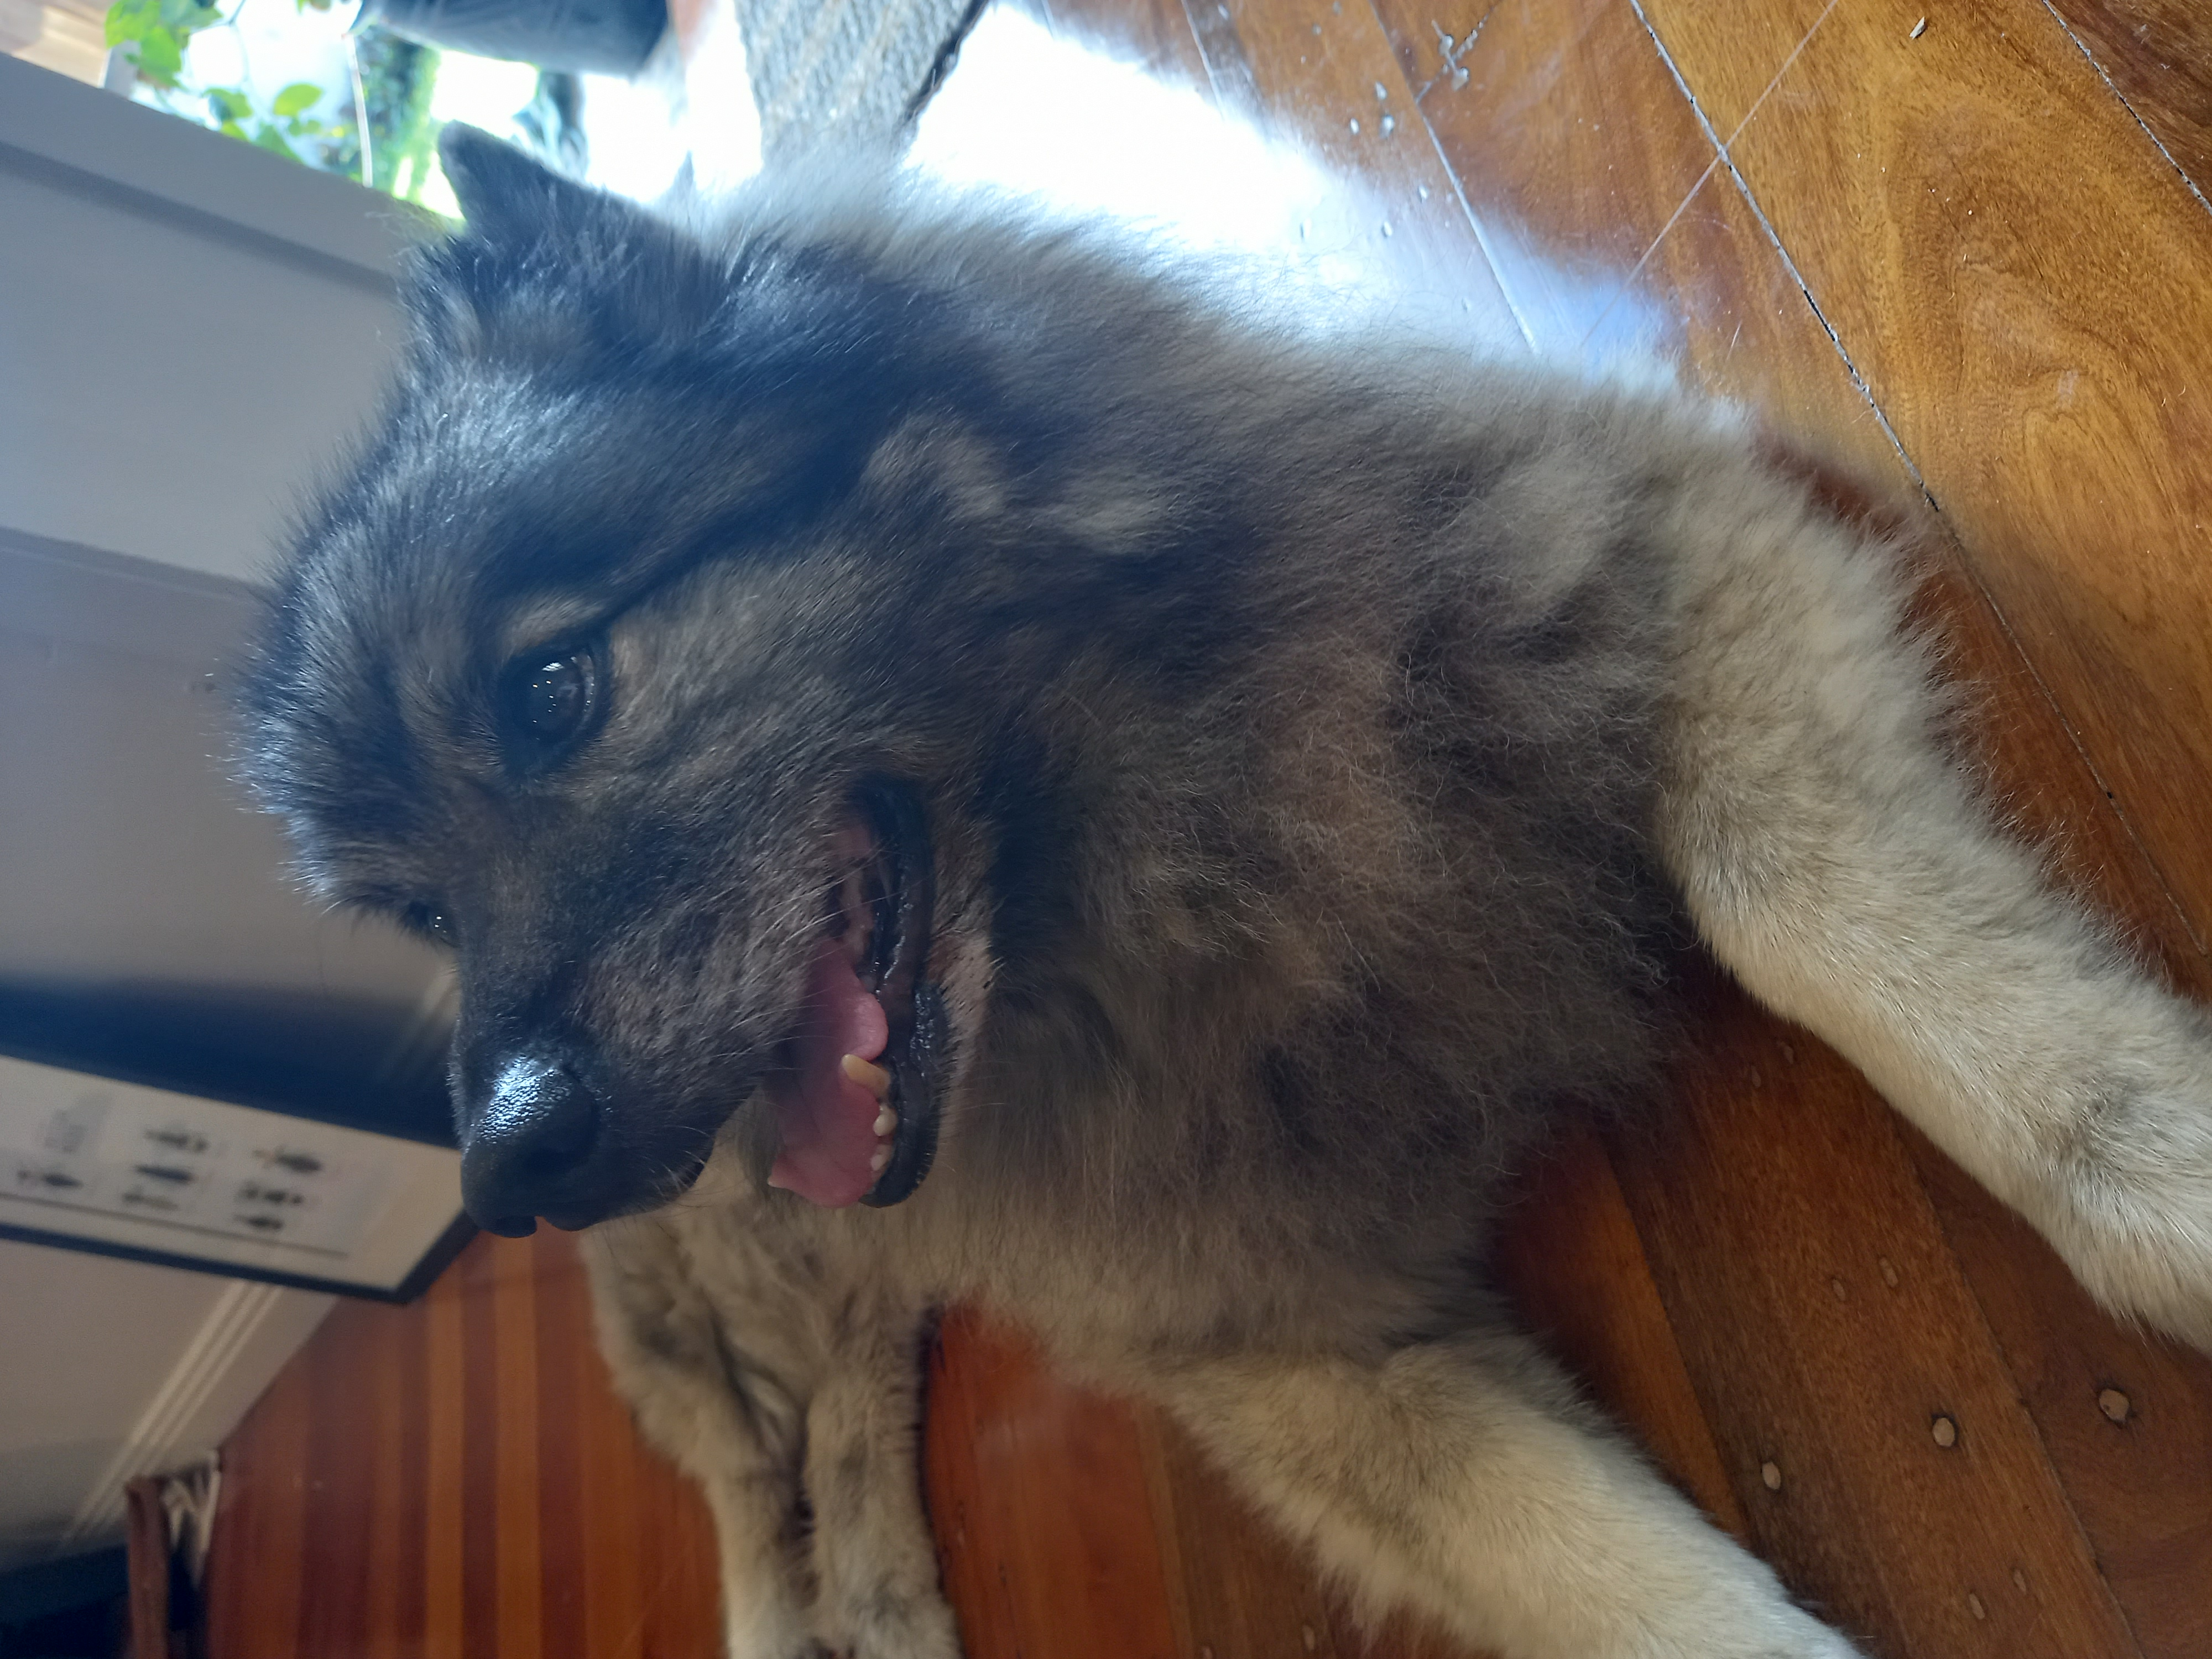

In [19]:
#import image of Jedi

file_name = 'jedi.jpg'
from IPython.display import Image
Image(file_name)

### Predict a test image

In [20]:
import json
import numpy as np

runtime = boto3.Session().client(service_name='runtime.sagemaker')

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=ic_predictor.endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

result = response['Body'].read()
result = json.loads(result)
index = np.argmax(result)
print(result[index], index)

# You should see class index 1 (probability of dog > 0.5), corresponding to the 'dog' class

0.7925075888633728 1


In [16]:
ic_predictor.delete_endpoint()

## 2. Training the build in CV Algorithm in SageMaker with Record IO files 

We now show how to use built-in CV algorithm in SageMaker for RecordIO. RecodIO files are more efficient because they enable the algorithm to read a large sequential file than to read a lot of files. RecordIO is the recommended input. 

We will again work with dogsvscats example. The first step is to convert images into RecordIO files. (It is easier to work on terminal)

Code for built-in CV algorithm is from here https://github.com/PacktPublishing/Learn-Amazon-SageMaker/blob/master/sdkv2/ch5/Image%20Classification%20on%20Dogs%20vs%20Cats%20(RecordIO).ipynb

Just like last week, the following code needs to be run in the jupyterlab terminal: 

In [ ]:
unzip dogs-vs-cats.zip
unzip train.zip

In [ ]:
cd train 
mkdir dog cat
find . -name 'dog.*' -exec mv {} dog \;
find . -name 'cat.*' -exec mv {} cat \;

Run im2rec to generate list files for the training data (80%) and validation dataset (20%). We will let imrec2 automatically ransomise the data into a training (80%) and test (20%) set

In [ ]:
wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
pip install mxnet opencv-python

In [ ]:
python3 im2rec.py --list --recursive --train-ratio 0.8 dogscats .

Run im2rec again to generate the recordIO files. 

This will create 4 files: 

- 2 RecordIO files (.rec) containing the packed images
- 2 index files (.idc) containing the offsets of these images 

in the record files

In [ ]:
python3 im2rec.py --num-thread 8 dogscats .

In [ ]:
ls 

Push the RecordIO files to S3

In [ ]:
aws s3 cp dogscats_train.rec s3://sagemaker-ap-southeast-2-580121432832/recordIO/dogscats/input/train/

In [ ]:
aws s3 cp dogscats_val.rec s3://sagemaker-ap-southeast-2-580121432832/recordIO/dogscats/input/validation/

### Train model using built-in CV algorithm for RecordIO files
Now we can move into a normal jupyter notebook

In [1]:
import boto3
import sagemaker

print(sagemaker.__version__)

session = sagemaker.Session()
bucket = session.default_bucket()

2.42.0


In [3]:
prefix = 'recordIO/dogscats'
s3_train_path = 's3://{}/{}/input/train/'.format(bucket, prefix)
s3_val_path   = 's3://{}/{}/input/validation/'.format(bucket, prefix)
s3_output     = 's3://{}/{}/output/'.format(bucket, prefix)

print(s3_train_path)
print(s3_val_path)
print(s3_output)

s3://sagemaker-ap-southeast-2-580121432832/recordIO/dogscats/input/train/
s3://sagemaker-ap-southeast-2-580121432832/recordIO/dogscats/input/validation/
s3://sagemaker-ap-southeast-2-580121432832/recordIO/dogscats/output/


In [4]:
from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('image-classification', region)
print(container)

544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/image-classification:1


In [9]:
role = sagemaker.get_execution_role()

ic = sagemaker.estimator.Estimator(container,
                                   role, 
                                   instance_count=1, 
                                   instance_type="ml.p2.xlarge", #'ml.p3.2xlarge' if requested
                                   output_path=s3_output)

In [10]:
ic.set_hyperparameters(num_layers=18,               # 5 layers
                       use_pretrained_model=0,      # Train from scratch
                       num_classes=2,               # Dogs and cats
                       num_training_samples=22500,  # Number of training samples
                       mini_batch_size=128,
                       epochs=5) 

In [11]:
train_data = sagemaker.TrainingInput(s3_train_path, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-recordio',
                                        s3_data_type='S3Prefix')

validation_data = sagemaker.TrainingInput(s3_val_path,
                                             distribution='FullyReplicated', 
                                             content_type='application/x-recordio', 
                                             s3_data_type='S3Prefix')

s3_channels = {'train': train_data, 'validation': validation_data}

In [12]:
ic.fit(inputs=s3_channels)

2021-06-02 23:25:57 Starting - Starting the training job...
2021-06-02 23:26:20 Starting - Launching requested ML instancesProfilerReport-1622676357: InProgress
......
2021-06-02 23:27:22 Starting - Preparing the instances for training............
2021-06-02 23:29:21 Downloading - Downloading input data...
2021-06-02 23:29:47 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
[06/02/2021 23:30:38 INFO 140150857807680] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[06/02/2021 23:30:38 INFO 140150857807680] Merging with provided configuration from /opt/ml/input/config/hy

Deploy and train the model is similar to the CV algorithm for the Image Format.